# Análisis y reporte sobre el desempeño de un modelo de Machine Learning

##### Samuel Méndez Villegas - A01652277

En este reporte se realiza un análisis sobre el desempeño de un modelo de aprendizaje supervisado sobre una base de datos de individuos con diabetes. El modelo que se evaluará se trata de un 'Random Forest Classifier' y con este se busca predecir si una persona padece de diabetes o no tomando en cuenta diferentes factores. 

Para la evaluación del modelo se tomaran en cuenta algunas métricas de evaluación como lo es el 'accuracy', el 'Mean Squared Error', el 'Mean Absolute Error' y la matriz de confusión para de igual forma evaluar la cantidad de falsos positivos y falsos negativos que se tienen. De igual forma se analizará el nivel de sesgo del modelo, así como su grado de varianza.

De igual forma, se realizará la evaluación del desempeño de un modelo de regresión, ya que son en este tipo de modelos en los que se puede evaluar de mejor forma el sesgo y la varianza a través del mae y mse, pues son métricas de evaluación de problemas de regresión.

In [1]:
## Librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Librerías para implementar el modelo
from sklearn.model_selection import train_test_split # Separar el set de datos en entrenamiento y prueba
from sklearn.ensemble import RandomForestClassifier # Clasificador a utilizar
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score # Medidas de evaluación

### Exploración de la base de datos
Comenzaremos cargando la base de datos y realizando un análsis exploratorio de los datos. Este paso es importante de realizar antes de implementar cualquier modelo de machine learning debido a que si la calidad de los datos que se utilizan no es buena, el modelo generado no será bueno. Esto hace mucha alusión a la frase "Trash in, trash out", que hace énfasis en la calidad y tratamiento de los datos.

En las siguientes celdas se muestra un poco de toda la limpieza generada. 

In [2]:
## Carga de los datos a utilizar
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
## Dimensiones del data frame
df.shape

(768, 9)

In [4]:
## Información de las variables dentro de la base de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


En el resumen anterior se puede observar que no se tienen valores nulos en ninguna de las columnas de la base de datos, y que no hay variables cualitativas, es decir únicamente se cuentan con variables cuantitativas. Sin embargo, seguiremos indagando un poco dentro de la base de datos.

In [5]:
## Evaluación de datos duplicados
df.duplicated().sum()

0

In [6]:
## Evaluación de datos nulos
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Se observa que no hay registros duplicados, y tampoco se cuentan con valores nulos en la base de datos, lo cual es relativamente bueno, pues en pocas palabras se tiene más información con la que entrenar al modelo. 

Ahora, se pasará a realizar un pequeño análisis descriptivo de las variables numéricas que se encuentran dentro del set de datos. 

In [7]:
## Análisis descriptivo de las variables numéricas
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


En este breve resumen podemos ver algunas cosas interesantes. Por ejemplo, si observamos el valor mínimo algunas variables como 'Glucose', 'Blood Presure', 'Skin Thickness', entre otras, se tiene un valor de 0. Esto es muy dudoso, ya que según la descripción de las variables, es imposible tener estos valores. Pongamos como ejemplo la presión sanguínea o el índice de masa corporal (BMI), pues es prácticamente imposible que una persona tenga valores de 0 en estos atributos. Por lo tanto, vamos a identificar estos registros y ver la información que contienen.

In [8]:
## Subconjunto de regitros con valores mínimos equivalentes a 0.
df.loc[(df['Glucose'] == 0) | (df['BloodPressure'] == 0) | (df['SkinThickness'] == 0) | (df['Insulin'] == 0) | (df['BMI'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


Como se puede observar son varios registros que contienen al menos uno de estos valores en 0. Estos ceros podrían en realidad simbolizar valores ausentes que en lugar de registrarse como nulos, se registraron como 0. Sin embargo esto puede ser una complicación para el modelo que se genere, por lo que de momento se pasara a elimanar estos registros y únicamente trabajar con aquellos que verdaderamente estén completos. 

In [9]:
## Nuevo conjunto de datos con el que se trabajará
df = df[(df['BloodPressure'] > 0) & (df['Glucose'] > 0) & (df['SkinThickness'] > 0) & (df['Insulin'] > 0) & (df['BMI'] > 0)]
df.shape

(392, 9)

Por supuesto que esta decisión de no tomar en cuenta los registros con valores faltantes no es la mejor, ya que como se puede observar, es muchísima la información que se pierde. Sin embargo como el objetivo de este proyecto es únicamente evaluar el desempeño de una implementación, de momento se aplicará esta técnica.

Si volvemos a aplicar el análisis descriptivo, observamos que ya no se tienen valores mínimos de 0, lo cual tiene sentido en el contexto del problema.

In [10]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Sin embargo, del anterior análisis aún se pueden encontrar varios detalles como que el valor máximo de embarazos que tuvo una mujer fue de 17, o que el BMI de una persona sea de 67.1. Para esto, pasaremos a visualizar a través de algunas gráficas el comportamiento de las distintas variables.

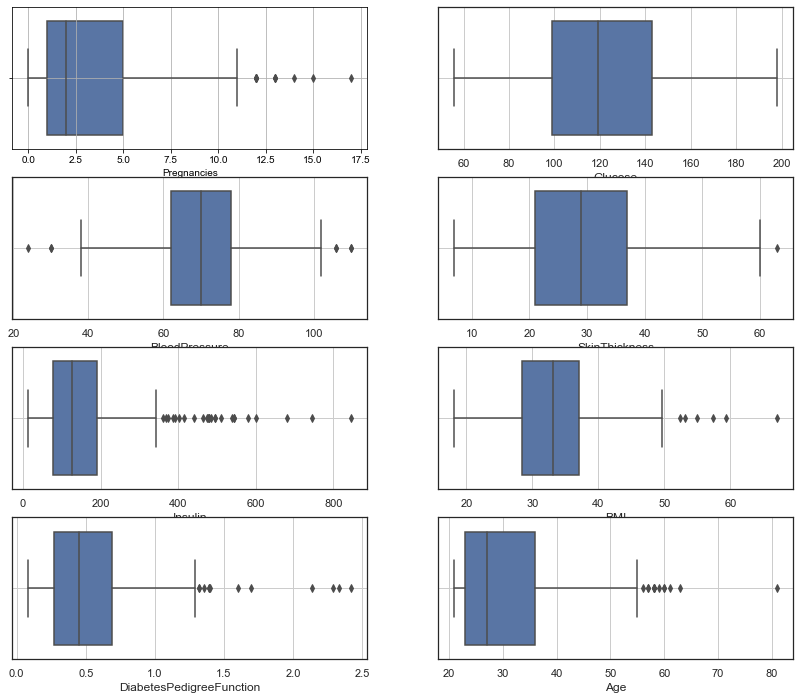

In [11]:
## Diagramas de caja y bigotes
plt.figure(figsize=(14, 12))
plt.subplot(4,2, 1)
sns.set_theme(style='white')
ax = sns.boxplot(x=df['Pregnancies'])
#plt.title('Diagrama de caja Pregnancies')
plt.grid()

plt.subplot(4,2, 2)
sns.set_theme(style='white')
ax = sns.boxplot(x=df['Glucose'])
#plt.title('Diagrama de caja Glucose')
plt.grid()

plt.subplot(4,2, 3)
sns.set_theme(style='white')
ax = sns.boxplot(x=df['BloodPressure'])
#plt.title('Diagrama de caja Blood Pressure')
plt.grid()

plt.subplot(4,2, 4)
sns.set_theme(style='white')
ax = sns.boxplot(x=df['SkinThickness'])
#plt.title('Diagrama de caja SkinThickness')
plt.grid()

plt.subplot(4,2, 5)
sns.set_theme(style='white')
ax = sns.boxplot(x=df['Insulin'])
#plt.title('Diagrama de caja Insulin')
plt.grid()

plt.subplot(4,2, 6)
sns.set_theme(style='white')
ax = sns.boxplot(x=df['BMI'])
#plt.title('Diagrama de caja BMI')
plt.grid()

plt.subplot(4,2, 7)
sns.set_theme(style='white')
ax = sns.boxplot(x=df['DiabetesPedigreeFunction'])
#plt.title('Diagrama de caja DiabetesPedigreeFunction')
plt.grid()

plt.subplot(4,2, 8)
sns.set_theme(style='white')
ax = sns.boxplot(x=df['Age'])
#plt.title('Diagrama de caja Age')
plt.grid()

En los diagrama de caja anteriores se puede observar que se tienen varios valores atípicos en muchas de las variables, sobre todo en la variable de insulina. Estos valores también los podemos observar en los siguientes histogramas.

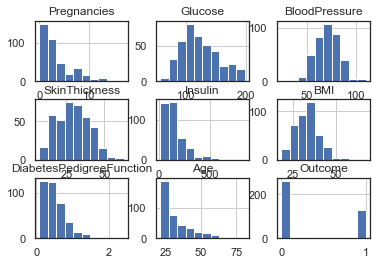

In [12]:
## Histogramas de frecuencia de las variables
df.hist()
plt.show()

Ya que se analizaron de forma muy, pero muy general los datos, se pasará a construir el Random Forest Classifier con ayuda de la librería `scikitlearn`.

### Construcción de un modelo de ML. Random Forest Classifier

#### Separación y evaluación del modelo con un conjunto de prueba y un conjunto de validación (Train/Test/Validation).
Antes de construir el modelo se realizará una partición del conjunto de datos total en 2 diferentes sets. El primero se destinará al entrenamiento del modelo y se le conocerá como set de entrenamiento. Por otro lado, el segundo set estará destinado a evaluar el modelo realizando predicciones con datos que el modelo nunca antes había visto. De esta forma se logrará conocer el desempeño del modelo en un espacio alejado al del entrenamiento, es decir qué tan robusto, o sensible será. 

Para esto, se van a utilizar todas las variables de la base de datos como variables predictoras, exceptuando el 'Outcome', la cual contiene las observaciones de si una persona tiene diabetes o no. 

In [13]:
## Variables predictoras
x = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

## Variable objetivo
y = df['Outcome']

In [14]:
## Separación de la base de datos en un set de entrenamiento y evaluación
X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
X_train.shape, x_test.shape, Y_train.shape, y_test.shape

((313, 8), (79, 8), (313,), (79,))

Como se observa en el pedazo de código anterior, se está realizando la partición de la base de datos en 2. El 80% de los datos se destinarán a entrenar el modelo, mientras que el otro 20% a su evaluación. Cabe mencionar que se está agregando un `random_state` con el objetivo de realizar todo este proyecto replicable. 

Una vez separada en conjuntos la base de datos, se pasa a implementar el modelo de machine learning de `RandomForestClassifier` sin la modificación de sus hiperparámetros, es decir se aplicará el modelo por default que viene. 

In [15]:
# Implementación del random forest classifier con los hiperparámetros default
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train) ## Entrenamiento del modelo

RandomForestClassifier()

Una vez elaborado el entrenamiento, se pasará a realizar predicciones. Para estas primeras predicciones se utilizará el mismo conjunto con el que se entrenó el modelo, ya que estó ayudará a ver si realmente el modelo es capaz de predecir de forma correcta los registros. Para evaluar qué tan bien lo hizo el modelo, se obtienen las siguientes métricas de evaluación del modelo como el MSE, MAE, Accuracy y matriz de confusión. 

In [16]:
## Se realizan las predicciones con el set de entrenamiento
train_results = rfc.predict(X_train)

In [17]:
## Se obtienen algunas medidas de evaluación como el mse, mae, la exactitud y la matriz de confusión
mse = mean_squared_error(train_results, Y_train)
mae = mean_absolute_error(train_results, Y_train)

print('Resultados de las predicciones con el set de entrenamiento:')
print('MSE con el conjunto de entrenamiento:', mse)
print('MAE con el conjunto de entrenamiento:', mae)
print("Accuracy con el conjunto de prueba:", accuracy_score(Y_train, train_results)) ## Indica que tanto el modelo clasificó correctamente
print(confusion_matrix(train_results, Y_train)) # Se muestra la matriz de confusión

Resultados de las predicciones con el set de entrenamiento:
MSE con el conjunto de entrenamiento: 0.0
MAE con el conjunto de entrenamiento: 0.0
Accuracy con el conjunto de prueba: 1.0
[[210   0]
 [  0 103]]


<AxesSubplot:>

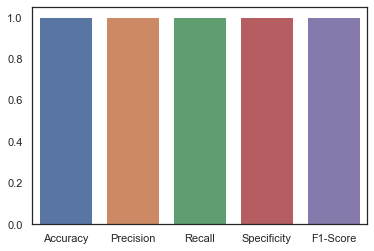

In [18]:
## Otras métricas de evaluación

con_mat = confusion_matrix(train_results, Y_train)
tp = con_mat[0][0]
tn = con_mat[1][1]
fp = con_mat[1][0]
fn = con_mat[0][1]

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall= tp/(tp+fn)
specificity = tn/(tn+fp)
f1_score = 2*((recall*precision)/(recall+precision))

metrics = [accuracy, precision, recall, specificity, f1_score]
labels = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']

sns.barplot(x = labels, y = metrics)

Cómo se puede observar, el desempeño del modelo, según los resultados de la métricas de evaluación, es extremadamente bueno, ya que tanto el Mean Squared Error, como el Mean Absolute Error tienen un valor de 0. De igual forma, el Acurracy, el cual indica qué tanto el modelo clasifica correctamente la clase, tiene un valor de 1, lo cual simboliza que clasifica correctamente el 100% de la veces. Esto último también se refleja en la matriz de confusión, en donde se puede observar que todas las predicciones caen en los campos de verdaderos positivos y verdaderos negativos. Es decir que no hay ningún registro catalogado como falso positivo ni como falso negativo.

Sin duda, el modelo parece ser genial, pues con una exactitud del 100% clasifica correctamente un registro. Sin embargo, ¿qué pasa si realizamos las predicciones en el cnjunto de evaluación? a continuación se realizan las predicciones para el conjunto de prueba.

In [19]:
## Con los datos de prueba
test_results = rfc.predict(x_test)

In [20]:
## Se obtienen algunas medidas de evaluación como el mse, mae, la exactitud y la matriz de confusión
mse = mean_squared_error(test_results, y_test)
mae = mean_absolute_error(test_results, y_test)

print('Resultados de las predicciones con el set de prueba:')
print('MSE con el conjunto de prueba:', mse)
print('MAE con el conjunto de prueba:', mae)
print("Accuracy con el conjunto de prueba:", accuracy_score(y_test, test_results)) ## Indica que tanto el modelo clasificó correctamente
print(confusion_matrix(test_results, y_test)) # Se muestra la matriz de confusión

Resultados de las predicciones con el set de prueba:
MSE con el conjunto de prueba: 0.24050632911392406
MAE con el conjunto de prueba: 0.24050632911392406
Accuracy con el conjunto de prueba: 0.759493670886076
[[45 12]
 [ 7 15]]


<AxesSubplot:>

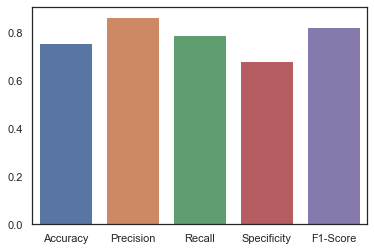

In [21]:
## Otras métricas de evaluación

con_mat = confusion_matrix(test_results, y_test)
tp = con_mat[0][0]
tn = con_mat[1][1]
fp = con_mat[1][0]
fn = con_mat[0][1]

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall= tp/(tp+fn)
specificity = tn/(tn+fp)
f1_score = 2*((recall*precision)/(recall+precision))

metrics = [accuracy, precision, recall, specificity, f1_score]
labels = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']

sns.barplot(x = labels, y = metrics)

Como se puede observar, aqui cambia mucho las cosas, pero iremos desglosando el desempeño parte por parte. Dos de los factores que son muy importantes evaluar del modelo, son su grado de sesgo y de varianza. Tanto el grado de sesgo, como el grado de varianza nos ayudan a comprender si existe un sobreajuste o un subajuste en el entrenamiento de los datos. Esto se debe a que nuestro error del modelo lo podemos interpretar como la suma del sesgo, la varianza y un error irreducible. 

#### Diagnóstico y explicación el grado de bias o sesgo: bajo medio alto
El sesgo se define como la distancia entre el valor real y el valor esperado del modelo. Por lo tanto, cuando tengamos un sesgo alto es sinónimo de tener un subajuste en los datos. Esto es debido a que la distancia entre el valor real y el esperado es muy grande. Por lo tanto, quiere decir que en realidad no le estamos 'atinando' correctamente a lo que queremos predecir. 

Como en este caso se está utilizando más de una variable predictora, no se puede visualizar el ajuste de los puntos e interpretar de una forma gráfica el sesgo. Por lo tanto, no basamos en otras métricas de evaluación como el error. En este caso, tanto en las predicciones con los datos de entrenamiento como en los de prueba, observamos que tanto el Mean Squared Error como el Mean Absolute Error son muy pequeños (0.227), pues están cercanos al 0. Por lo tanto, podemos decir que le estamos atinando a donde queremos. Por lo tanto, concluimos que el grado de de sesgo es bajo y por lo tanto no tenemos un subajuste en los datos. 

#### Diagnóstico y explicación el grado de varianza: bajo medio alto

La varianza se define como la distancia entre el valor esperado del modelo, y el valor entregado por el modelo. Al diferencia del sesgo, la varianza alta se puede traducir en tener un sobreajuste o no en nuestro modelo. De igual forma, este grado de variación se puede medir a través del error, el cual se descompone en el sesgo, la varianza y un error irreducible. 

En las predicciones del modelo con los datos de entrenamiento, se observa que se obtuvo un error de prácticamente cero, por lo que el grado de varianza es bajo y no se tiene un sobreajuste. Sin embargo, la cosa cambia cuando se evalúa el modelo con los datos de prueba, pues aqui vemos que los errore aumentan y la métrica de accuracy disminuye su valor. Esto indica que hay un grado de varianza alta, pues hay un sobreajuste en el modelo, pues es muy bueno para predecir cuando se le ingresan registros con los que entrenó, sin embargo, cuando se trata de nuevos registros, tiende a fallar.

#### Diagnóstico y explicación el nivel de ajuste del modelo: underfitt fitt overfitt
Finalmente, como se estuvo hablando en los puntos anteriores, el sesgo y varianza son sinónimos de subajuste y sobreajuste respectivamente. En este caso se tiene un modelo sobreajustado, dado a que el comportamiento de las métricas de evaluación cambia bastante cuando se trata del conjunto de prueba, o del conjunto de entrenamiento. Un modelo no sobreajustado no sería perfecto prediciendose a si mismo como lo es en este caso. 

En conclusión, el modelo contruido es muy malo, pues cuenta con un sobreajuste de datos, por lo que es pésimo para predecir si un paciente padece de diabetes si es un nuevo registro, o contiene combinaciones de valores de los factores que desconoce.


### Mejorando el modelo
Finalmente se pasará a mejorar el desempeño del modelo anteriormente construido. Para esto se realizará un ajuste en los hiperparámetros del modelo, pues recordemos que cada modelo cuenta con distintos parámetros que lo ajustan. En este caso se aumentará el número de árboles creados, además de reducir la profundidad de los distintos árboles con el objetivo de evitar un sobreajuste en los datos. De igual forma se utiliza un random state para hacer todo este proceso replicable. 

Sin embargo, otra de las técnicas que se puede aplicar para mejorar el modelo es el pre procesamiento de los datos, es decir reducir variables, o quedarnos con aquellas que aportan más a nuestro modelo. Para ello, podemos construir una matriz de correlación como la siguiente:

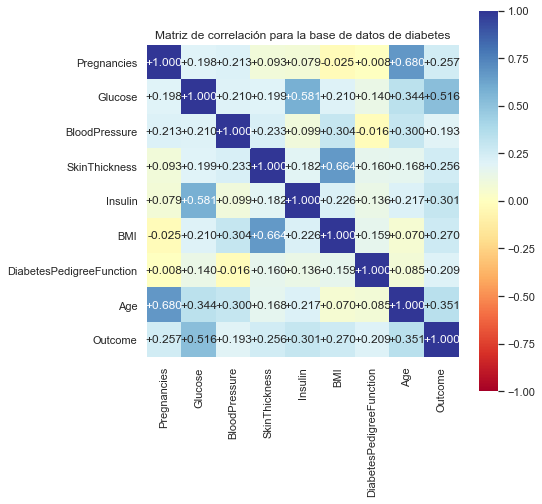

In [22]:
## Matriz de correlación
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), cmap="RdYlBu", 
    annot=True, square=True,
    vmin=-1, vmax=1, fmt="+.3f")
plt.title("Matriz de correlación para la base de datos de diabetes")
plt.show()

De la anterior matriz de correlación se puede observar una mediana relación entre la variable Outcome y la variable glucosa. Las demás varibles diria que tienen una relación media baja con la variable objetivo. Por lo tanto únicamente nos quedaremos con aquellas que son mayores a 0.25.

In [23]:
x = df[['Pregnancies', 'Glucose', 'SkinThickness', 
        'Insulin', 'BMI', 'Age']]

y = df['Outcome']

In [24]:
## Modificación de los hiperparámetros del modelo con el objetivo de mejorar el modelo
rfc = RandomForestClassifier(n_estimators = 5000, max_depth = 5, criterion = 'gini', random_state = 42)
rfc.fit(X_train, Y_train) ## Entrenamiento del modelo

RandomForestClassifier(max_depth=5, n_estimators=5000, random_state=42)

In [25]:
## Se realizan las predicciones en el conjunto de entrenamiento
train_results = rfc.predict(X_train)

In [26]:
## Se obtienen algunas de las medidas de evaluación
mse = mean_squared_error(train_results, Y_train)
mae = mean_absolute_error(train_results, Y_train)

print('Resultados de las predicciones con el set de entrenamiento:')
print('MSE con el conjunto de entrenamiento:', mse)
print('MAE con el conjunto de entrenamiento:', mae)
print("Accuracy con el conjunto de prueba:", accuracy_score(Y_train, train_results)) ## Indica que tanto el modelo clasificó correctamente
print(confusion_matrix(train_results, Y_train)) # Se muestra la matriz de confusión

Resultados de las predicciones con el set de entrenamiento:
MSE con el conjunto de entrenamiento: 0.0926517571884984
MAE con el conjunto de entrenamiento: 0.0926517571884984
Accuracy con el conjunto de prueba: 0.9073482428115016
[[201  20]
 [  9  83]]


Desde este punto podemos ver la mejora del modelo con respecto al anterior, ya que al predecir con los valores de entrenamiento se observa que no se tiene un modelo perfecto, es decir que muy posiblemente no existe un sobreajuste, sin embargo, pasaremos a evaluar cómo se desempeña con las siguientes métricas:

<AxesSubplot:>

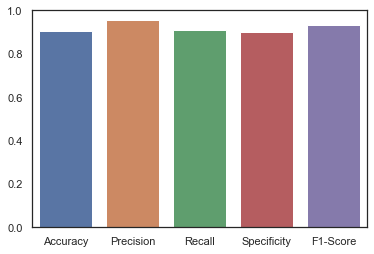

In [27]:
## Otras métricas de evaluación

con_mat = confusion_matrix(train_results, Y_train)
tp = con_mat[0][0]
tn = con_mat[1][1]
fp = con_mat[1][0]
fn = con_mat[0][1]

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall= tp/(tp+fn)
specificity = tn/(tn+fp)
f1_score = 2*((recall*precision)/(recall+precision))

metrics = [accuracy, precision, recall, specificity, f1_score]
labels = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']

sns.barplot(x = labels, y = metrics)

In [28]:
## Con los datos de prueba
test_results = rfc.predict(x_test)

In [29]:
mse = mean_squared_error(test_results, y_test)
mae = mean_absolute_error(test_results, y_test)
r2 = r2_score(test_results, y_test)

print('Resultados de las predicciones con el set de prueba:')
print('MSE con el conjunto de prueba:', mse)
print('MAE con el conjunto de prueba:', mae)
print("Accuracy con el conjunto de prueba:", accuracy_score(y_test, test_results)) ## Indica que tanto el modelo clasificó correctamente
print(confusion_matrix(test_results, y_test)) # Se muestra la matriz de confusión

Resultados de las predicciones con el set de prueba:
MSE con el conjunto de prueba: 0.24050632911392406
MAE con el conjunto de prueba: 0.24050632911392406
Accuracy con el conjunto de prueba: 0.759493670886076
[[45 12]
 [ 7 15]]


<AxesSubplot:>

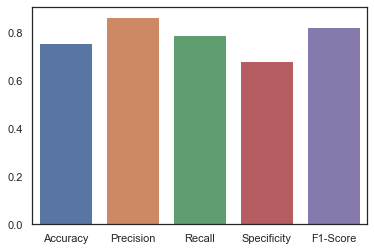

In [30]:
## Otras métricas de evaluación

con_mat = confusion_matrix(test_results, y_test)
tp = con_mat[0][0]
tn = con_mat[1][1]
fp = con_mat[1][0]
fn = con_mat[0][1]

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall= tp/(tp+fn)
specificity = tn/(tn+fp)
f1_score = 2*((recall*precision)/(recall+precision))

metrics = [accuracy, precision, recall, specificity, f1_score]
labels = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']

sns.barplot(x = labels, y = metrics)

Finalmente, con las predicciones al set de pruebas podemos decir que el modelo mejoró, muy poco, pero mejoró con respecto al anteriormente creado con los hiperparámetros pre establecidos. Esto es debido a que se crearon muchos más árboles de decisión, por lo que el entrenamiento se efectúo de una mucho mejor forma. De igual forma, al reducir la profundidad de los árboles creados, se evita el sobreajuste de los datos, y por lo tanto hace al modelo más robusto y tiene un porcentaje más alto de predicicón de la clase. 

Claro esta que este no es el mejor modelo que se puede implementar, pues se debe de indagar más combinaciones posibles de hiperparámetros, e inclusive pre-procesar más los datos utilizados, pues estos pueden estandarizarse, o transofrmarse para así tratar de mejor del desempeño del modelo creado. 

# Modelo de regresión 

Anteriormente se realizó un modelo de clasificación, sin embargo, es sabido que algunas métricas de evaluación como el MSE y el MAE se utilizan para regresiones. Por lo tanto, para poder analizar de una mejor forma estas métricas, se utilizará un modelo de regresión, pero ahora para predecir el `BMI` de los pacientes en lugar del `Outcome`.

Por lo tanto a continuación se muestra el proceso seguido:

In [31]:
from sklearn.ensemble import RandomForestRegressor

Ahora la variable objetivo será el `BMI`

In [32]:
## Variables predictoras
x = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
        'Insulin', 'DiabetesPedigreeFunction', 'Age', 'Outcome']]

## Variable objetivo
y = df['BMI']

In [33]:
## Separación de la base de datos en un set de entrenamiento y evaluación
X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
X_train.shape, x_test.shape, Y_train.shape, y_test.shape

((313, 8), (79, 8), (313,), (79,))

In [34]:
# Implementación del random forest Regressor con los hiperparámetros default
rfr = RandomForestRegressor()
rfr.fit(X_train, Y_train) ## Entrenamiento del modelo

RandomForestRegressor()

In [35]:
## Se realizan las predicciones con el set de entrenamiento
train_results_rfr = rfr.predict(X_train)

In [36]:
## Se obtienen algunas medidas de evaluación como el mse, mae, la exactitud y la matriz de confusión
mse = mean_squared_error(train_results_rfr, Y_train)
mae = mean_absolute_error(train_results_rfr, Y_train)
r2 = r2_score(train_results_rfr, Y_train)

print('Resultados de las predicciones con el set de entrenamiento:')
print('MSE con el conjunto de entrenamiento:', mse)
print('MAE con el conjunto de entrenamiento:', mae)
print('El coeficiente R^2:', r2)

Resultados de las predicciones con el set de entrenamiento:
MSE con el conjunto de entrenamiento: 3.7517934376996687
MAE con el conjunto de entrenamiento: 1.4381661341853018
El coeficiente R^2: 0.8890908444148738


Como podemos observar, cuando entrenamos nuestro regresor y posteriormente realizamos predicciones con el mismo set de entrenamiento, unos errores la verdad bastante pequeños, y un coeficiente de R^2 cercano a 1, indicando de esta forma que el modelo es bueno. Sin embargo, ¿Qué es lo que sucede con el sego y la varianza? Bueno, eso se puede inerpretar en la siguiente gráfica en la cual se tienen graficadas las predicciones realizadas y los valores reales de esas predicciones del conjunto de entrenamiento. Como se observa el sesgo es bastante bajo, pues las dos curvas se parecen bastante, sin embargo, para la varianza se debe de implementar nuevamente el modelo pero con otro conjunto de datos. Para ello, cambiaremos la semilla al dividir el set de entrenamiento, con el objetivo de ver la variación entre los modelos.

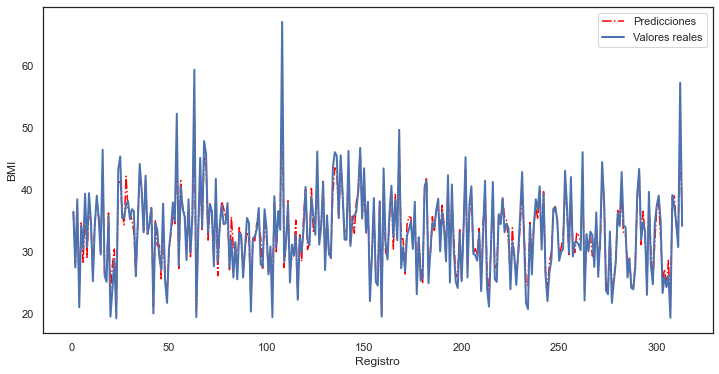

In [37]:
x_labels = np.arange(1,314)

plt.figure(figsize=(12,6))
plt.plot(x_labels,train_results_rfr, label='Predicciones', c = 'red',linestyle = '-.' )
plt.plot(x_labels, Y_train, linewidth = 2, label= 'Valores reales' )
plt.legend()
plt.xlabel('Registro')
plt.ylabel('BMI') 
plt.show()

In [38]:
semillas = [42, 15, 78] # Semillas a utilizar
predicciones = [] # lista en donde se guardaran las predicciones de cada modelo

for i in range(len(semillas)):
    ## Separación de la base de datos en un set de entrenamiento y evaluación
    X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = semillas[i])
    
    rfr = RandomForestRegressor()
    rfr.fit(X_train, Y_train) ## Entrenamiento del modelo
    
    ## Se realizan las predicciones con el set de entrenamiento
    predicciones.append(rfr.predict(X_train))
    
    mse = mean_squared_error(predicciones[i], Y_train)
    mae = mean_absolute_error(predicciones[i], Y_train)
    r2 = r2_score(predicciones[i], Y_train)
    
    print('\nResultados de las predicciones con el set de entrenamiento', i+1)
    print('MSE con el conjunto de entrenamiento:', mse)
    print('MAE con el conjunto de entrenamiento:', mae)
    print('El coeficiente R^2:', r2)
    print('------------------------------------------------------------' )


Resultados de las predicciones con el set de entrenamiento 1
MSE con el conjunto de entrenamiento: 4.14500914376996
MAE con el conjunto de entrenamiento: 1.485290734824279
El coeficiente R^2: 0.8737908983156224
------------------------------------------------------------

Resultados de las predicciones con el set de entrenamiento 2
MSE con el conjunto de entrenamiento: 3.7818042939297114
MAE con el conjunto de entrenamiento: 1.5048306709265196
El coeficiente R^2: 0.8871736864704194
------------------------------------------------------------

Resultados de las predicciones con el set de entrenamiento 3
MSE con el conjunto de entrenamiento: 3.825561079872205
MAE con el conjunto de entrenamiento: 1.5000766773162943
El coeficiente R^2: 0.88799550571181
------------------------------------------------------------


En cuanto a la varianza, la cual se puede medir viendo la diferencia entre los errores entre los modelos, se observa que es muy mínima, pues todas la métricas obtenidas son similare entre ellas. Si se quiere ver esto de una forma gráfica, se pueden graficar todas las predicciones obtenidas y observar como todas las curvas son parecidas.

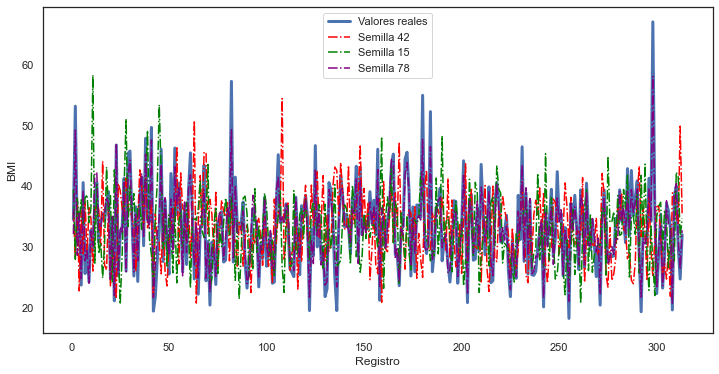

In [39]:
x_labels = np.arange(1,314)

plt.figure(figsize=(12,6))
plt.plot(x_labels, Y_train, linewidth = 3, label= 'Valores reales' )
plt.plot(x_labels, predicciones[0], label='Semilla 42', c = 'red', linestyle = '-.')
plt.plot(x_labels, predicciones[1], label='Semilla 15', c = 'green', linestyle = '-.')
plt.plot(x_labels, predicciones[2], label='Semilla 78', c = 'purple', linestyle = '-.')

plt.legend()
plt.xlabel('Registro')
plt.ylabel('BMI') 
plt.show()

Por lo tanto, concluimos este modelo se tienen tanto un sesgo bajo como una varianza baja, por lo que se traduce en un buen modelo, sin embargo, al realizar las predicciones con el set de entrenamiento, puede que haya un sobreajuste en los datos.

Finalmente, pasaremos a implementar el modelo, pero con un ajuste de hiperparámetros, así como realizar las predicciones directamente con el conjunto de pruebas y no con el de entrenamiento. 


In [40]:
rfr = RandomForestRegressor(n_estimators=500, max_depth=7)

In [41]:
semillas = [42, 15, 78] # Semillas a utilizar
predicciones = [] # lista en donde se guardaran las predicciones de cada modelo

for i in range(len(semillas)):
    ## Separación de la base de datos en un set de entrenamiento y evaluación
    X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = semillas[i])
    
    rfr = RandomForestRegressor()
    rfr.fit(X_train, Y_train) ## Entrenamiento del modelo
    
    ## Se realizan las predicciones con el set de entrenamiento
    predicciones.append(rfr.predict(x_test))
    
    mse = mean_squared_error(predicciones[i], y_test)
    mae = mean_absolute_error(predicciones[i], y_test)
    r2 = r2_score(predicciones[i], y_test)
    
    print('\nResultados de las predicciones con el set de entrenamiento', i+1)
    print('MSE con el conjunto de entrenamiento:', mse )
    print('MAE con el conjunto de entrenamiento:', mae)
    print('El coeficiente R^2:', r2)
    print('------------------------------------------------------------' )


Resultados de las predicciones con el set de entrenamiento 1
MSE con el conjunto de entrenamiento: 24.952215620253142
MAE con el conjunto de entrenamiento: 4.061544303797467
El coeficiente R^2: -0.09726138719557365
------------------------------------------------------------

Resultados de las predicciones con el set de entrenamiento 2
MSE con el conjunto de entrenamiento: 21.748737886075943
MAE con el conjunto de entrenamiento: 3.7919367088607574
El coeficiente R^2: 0.2104140074455435
------------------------------------------------------------

Resultados de las predicciones con el set de entrenamiento 3
MSE con el conjunto de entrenamiento: 24.408855734177244
MAE con el conjunto de entrenamiento: 3.856341772151899
El coeficiente R^2: -0.007214184811668689
------------------------------------------------------------


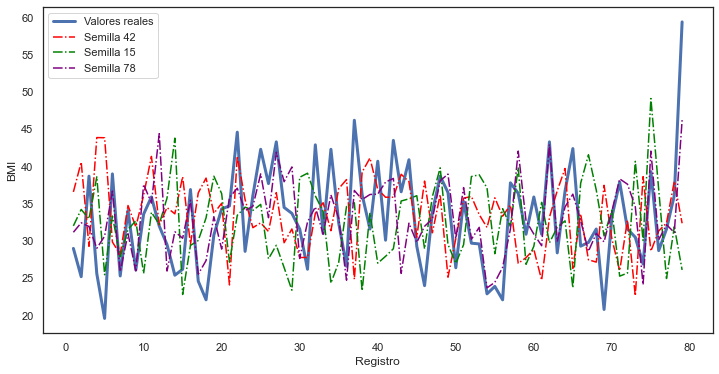

In [42]:
x_labels = np.arange(1,80)

plt.figure(figsize=(12,6))
plt.plot(x_labels, y_test, linewidth = 3, label= 'Valores reales' )
plt.plot(x_labels, predicciones[0], label='Semilla 42', c = 'red', linestyle = '-.')
plt.plot(x_labels, predicciones[1], label='Semilla 15', c = 'green', linestyle = '-.')
plt.plot(x_labels, predicciones[2], label='Semilla 78', c = 'purple', linestyle = '-.')

plt.legend()
plt.xlabel('Registro')
plt.ylabel('BMI') 
plt.show()

Como se puede observar en este último modelo obtenido, se puede apreciar que ya no se tiene un tan buen modelo, pues tanto el valor del mse, como del mae aumentaron, mientras que el R^2 disminuyó De igual forma, si se aprecian las gráficas obtenidas comparando las diferentes predicciones con el valor real, se observa que las curvas ya no son tan parecidas entre ellas. 

Esto último lo podemos analizar de mejor forma desde los terminos de sesgo y varianza. Comencemos con el sesgo. De manera gráfica, se observa que las curvas predictoras se acercan a la curva de los valores reales, sin embargo no tanto como lo hacia con el conjunto de entrenamiento. Esto puede ser un claro índice de sesgo en el modelo, y por lo tanto se puede traducir como un subajuste, ya que el modelo no está estimando de manera correcta los valores reales, lo cual también se puede argumentar con las métricas de evaluación de los modelos. 

En cuanto a la varianza, se puede observar que igual hay mucha más, pues las curvas varian mucho entre si. Esto se puede observar en el valor de R^2, pues vemos como la diferencia entre modelos de esta mética es muy grande. Recordemos que un alto sesgo es sinónimo de un sobreajuste de datos. 

Como conclusión, tenemos que un nuevo modelo con un sesgo medianamente alto, y una varianza alta. Por lo tanto, se puede decir que el modelo sufre de un sobreajuste y no es la mejor herramienta para determinar el `BMI` se una paciente.